## Milestone 1:
For the first milestone, each team should complete the following steps for the offered grade:

- Define the software environment (e.g. requirements.txt, Dockerfile, etc.)
- Data acquisition: indicating the data source, and how you downloaded it (Python script or IPYNB)
- Data preparation. Final output: training, validation and test inputs and outputs. (Python script or IPYNB)
- Containerization : initial version of the Dockerfile to be used later

To complete milestone 1, create a GitHub repository for your group with the following in readme.md:

- team name,
- team members' names and Neptun codes,
- project description,
- functions of the files in the repository,
- related works (papers, GitHub repositories, blog posts, etc),
-and how to run it (building and running the container, running your solution within the container).

In this assignment, you have to submit the URL of the solution. One submission per group is asked and needed.

Imports

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet, Flowers102
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torchvision.datasets import Flowers102, OxfordIIITPet
from PIL import Image

Reprodukálhatóság érdekében beállítunk egy seedet.

In [ ]:
torch.manual_seed(42)

### Data acquisition and analysis
Torchvisionben is elérhető flowers102 és OxfordIIIPet dataset kerül letöltésre kódból, amiket transzformálunk, hogy egységesek legyenek.

In [ ]:
flowers_dataset = Flowers102(root="./data", split="train", transform=None, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=None, download=True)

100%|██████████| 344862509/344862509 [00:10<00:00, 31471184.08it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 342642.90it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14230063.98it/s]


100%|██████████| 791918971/791918971 [00:24<00:00, 32542991.41it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14785549.71it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


Nézzük meg, hogy a datasetek képeinek milyen az osztály szerinti eloszlása, illetve mekkorák a képek.


In [ ]:
def plot_class_size_distribution(dataset, dataset_name):
    # Get the labels (class) for each image
    classes = [label for _, label in dataset]

    # Count the occurrences of each class
    class_counts = Counter(classes)

    # Get the class sizes (number of samples per class)
    class_sizes = list(class_counts.values())

    # Plot the histogram of class sizes
    plt.figure(figsize=(10, 6))
    sns.histplot(class_sizes, bins=30, kde=False)  # kde=False means no smooth curve, just bars
    plt.title(f"Class Size Distribution in {dataset_name} Dataset")
    plt.xlabel("Number of Samples per Class")
    plt.ylabel("Number of Classes")
    plt.show()

Flowers102 Dataset Class Distribution


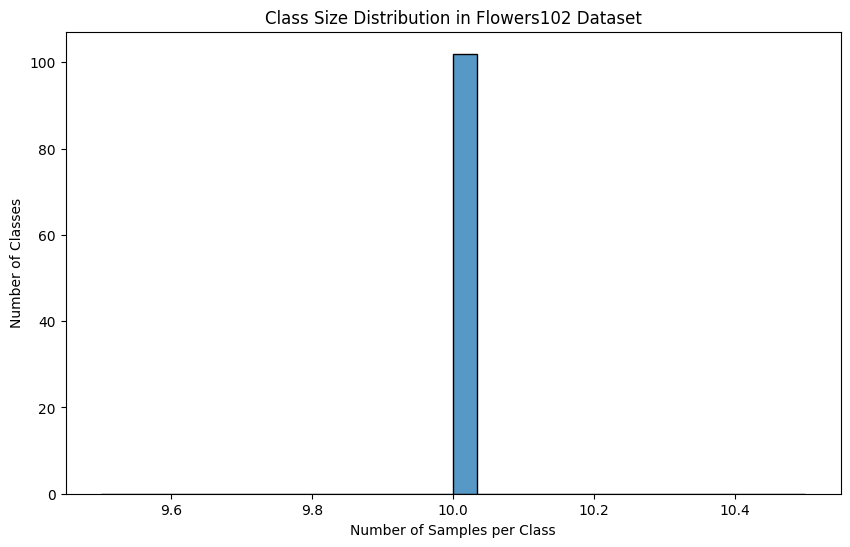


Oxford-IIIT Pet Dataset Class Distribution


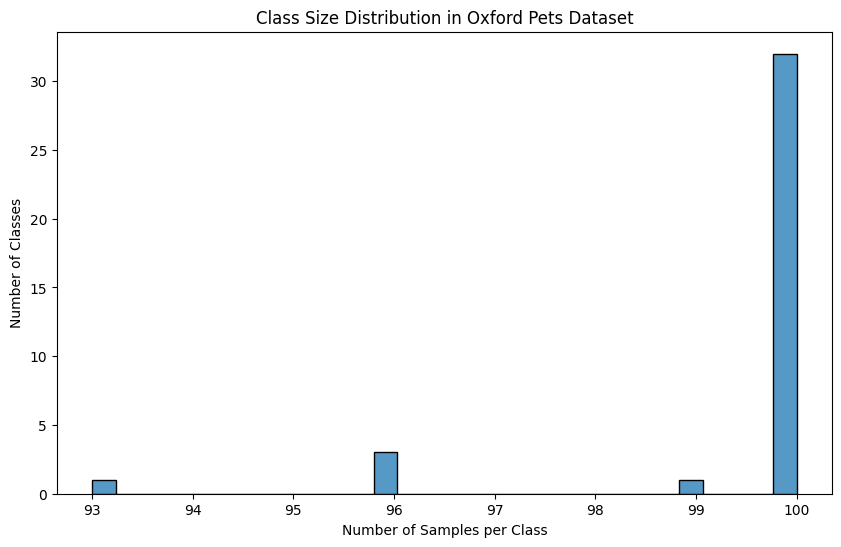

In [ ]:
print("Flowers102 Dataset Class Distribution")
plot_class_size_distribution(flowers_dataset, "Flowers102")

print("\nOxford-IIIT Pet Dataset Class Distribution")
plot_class_size_distribution(pets_dataset, "Oxford Pets")

Az előző két diagram alapján azt lehet mondani, hogy a flowers102 datasetben nincsenek eltérések eloszlást nézve, hiszen minden osztályban 10 minta van.


Viszont a Pets datasetben már vannak eltérések így ott azokat az osztályokat, amelyek 93 mintával rendelkeznek eldobjuk.


In [ ]:
def categorize_resolution(width, height):
    if 128 <= width < 256 and 128 <= height < 256:
        return 'Low (128-256)'
    elif 256 <= width < 512 and 256 <= height < 512:
        return 'Medium (256-512)'
    elif 512 <= width < 1024 and 512 <= height < 1024:
        return 'High (512-1024)'
    else:
      return 'Very High (>=1024)'


def plot_image_size_distribution(dataset, dataset_name):
    resolution_counts = {
        'Low (128-256)': 0,
        'Medium (256-512)': 0,
        'High (512-1024)': 0,
        'Very High (>=1024)': 0
    }
    for img, _ in dataset:
        if isinstance(img, str):
            img = Image.open(img)
        category = categorize_resolution(img.size[0], img.size[1])
        resolution_counts[category] += 1

    categories = list(resolution_counts.keys())
    counts = list(resolution_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.title(f'Image Size Distribution of {dataset_name} by Resolution Category')
    plt.xlabel('Resolution Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.show()


Flowers102 Dataset Image Size Analysis


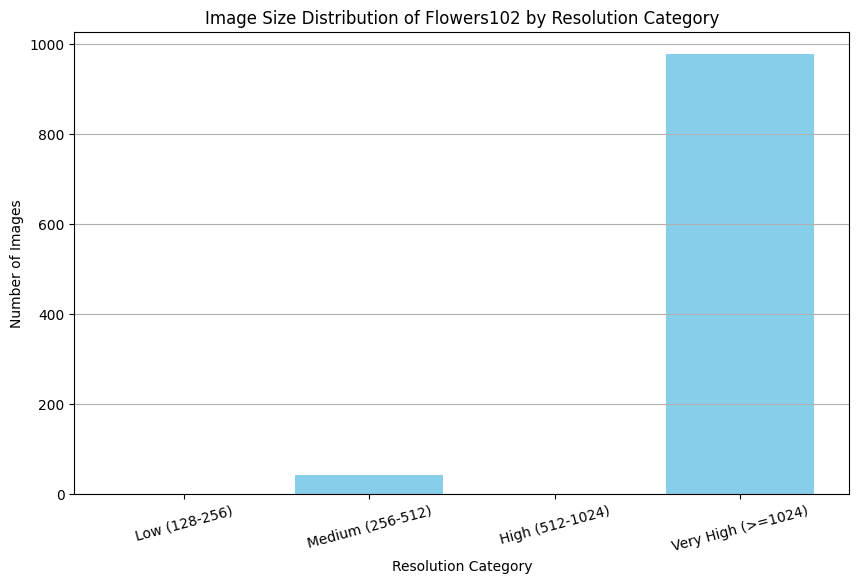


Oxford-IIIT Pet Dataset Image Size Analysis


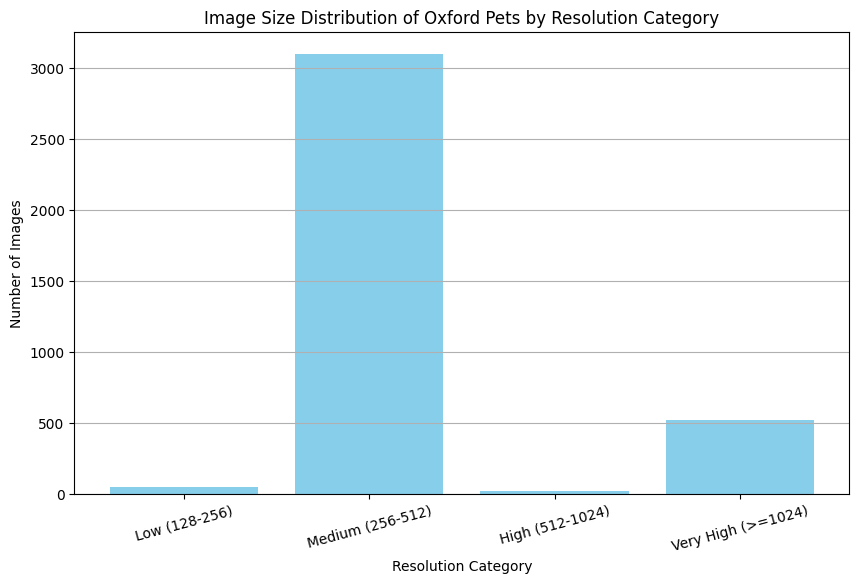

In [ ]:
print("\nFlowers102 Dataset Image Size Analysis")
plot_image_size_distribution(flowers_dataset, "Flowers102")

print("\nOxford-IIIT Pet Dataset Image Size Analysis")
plot_image_size_distribution(pets_dataset, "Oxford Pets")

Ez alapján a flowers datasetből érdemes eldobni a medium kategóriába tartozókat, illetve a pets datasetből a low és high kategóriájuakat.


### Data cleansing

In [ ]:
#Itt a data cleansinget kéne megvalósítani a két analízis során leírtak alapján, ha van más ötleted amit analizálnál az is jó

### Data preparation


Augmentációs transzformáció mert kicsik a datasetek, ezt csak a train adatokra alkalmazzuk.


In [ ]:
# Define transformations for data augmentation and normalization
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5), # Flip images horizontally with 50% chance
    transforms.RandomVerticalFlip(p=0.2),   # Flip images vertically with 20% chance
    transforms.RandomRotation(30),         # Rotate images by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)), # Randomly crop and resize
    transforms.ToTensor(),                # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize to [-1, 1] range
])

Sima transzformáció ezt csak a validációkra alkalmazzuk.

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Véletlenszerűen szétválasztjuk a datasetet a következő arányok szerint:
- Train: 70%
- Validation: 15%
- Test: 15%

Tekintettel arra, hogy a datasetjeink nagysága nem haladja meg a 10 000-et.

In [ ]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    return random_split(dataset, [train_size, val_size, test_size])

In [ ]:
flowers102_train, flowers102_val, flowers102_test = split_dataset(flowers_dataset)

oxford_pets_train, oxford_pets_val, oxford_pets_test = split_dataset(pets_dataset)

In [ ]:

flowers102_train_loader = DataLoader(flowers102_train, batch_size=64, shuffle=True)
flowers102_val_loader = DataLoader(flowers102_val, batch_size=64, shuffle=False)
flowers102_test_loader = DataLoader(flowers102_test, batch_size=64, shuffle=False)

oxford_pets_train_loader = DataLoader(oxford_pets_train, batch_size=64, shuffle=True)
oxford_pets_val_loader = DataLoader(oxford_pets_val, batch_size=64, shuffle=False)
oxford_pets_test_loader = DataLoader(oxford_pets_test, batch_size=64, shuffle=False)

In [ ]:
print(f"Flowers102 dataset: {len(flowers102_train)} training, {len(flowers102_val)} validation, {len(flowers102_test)} test samples")
print(f"Oxford-IIIT Pets dataset: {len(oxford_pets_train)} training, {len(oxford_pets_val)} validation, {len(oxford_pets_test)} test samples")

Flowers102 dataset: 714 training, 153 validation, 153 test samples
Oxford-IIIT Pets dataset: 2576 training, 552 validation, 552 test samples
